# Installations

In [38]:
!pip install torch-geometric rdkit periodictable mendeleev --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 41.3 MB/s eta 0:00:00


# Imports

In [2]:
import os
import random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch.utils.data import Dataset, DataLoader

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import (
    TransformerConv,
    TopKPooling,
    global_mean_pool as gap,
    global_max_pool as gmp,
    GINConv,
    GATConv
)

from rdkit import Chem
from rdkit.Chem import Draw, rdMolDescriptors, Descriptors, Crippen, Lipinski

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import periodictable
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

# Dataset

In [3]:
DATASET_PATH = "/kaggle/input/hiv-inhibit-classification/HIV.csv"
df = pd.read_csv(DATASET_PATH)
print(df.head())

                                              smiles activity  HIV_active
0  CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...       CI           0
1  C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...       CI           0
2                   CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21       CI           0
3    Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1       CI           0
4                             O=S(=O)(O)CCS(=O)(=O)O       CI           0


In [4]:
class HIVDataset(Dataset):
    def __init__(self, dataframe):
        """
        Initialize the dataset with a pandas DataFrame containing the SMILES strings 
        and the activity labels.
        """
        self.dataframe = dataframe
        self.valid_indices = []

        for idx in range(len(self.dataframe)):
            smiles = self.dataframe.iloc[idx]['smiles']
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                self.valid_indices.append(idx)

    def __len__(self):
        """
        Return the number of valid samples in the dataset.
        """
        return len(self.valid_indices)

    def __getitem__(self, idx):
        """
        Return the graph representation of a single molecule sample, along with its activity label.
        """
        valid_idx = self.valid_indices[idx]
        row = self.dataframe.iloc[valid_idx]
        smiles = row['smiles']
        label = int(row['HIV_active'])
        
        graph = smiles_to_graph(smiles)
        graph.y = torch.tensor([label], dtype=torch.long)
        return graph

# Feature Extraction & Graph Construction

In [76]:
def get_atom_features(atom):
    """
    Extracts a set of features for a given atom, including periodic table information,
    using the periodictable library to look up period and group instead of hardcoding.
    """
    features = []
    
    atomic_number = atom.GetAtomicNum()
    features.append(atomic_number)
    
    symbol = atom.GetSymbol()
    try:
        elem = periodictable.elements.symbol(symbol)
        period = elem.period
        group = elem.group
    except Exception:
        period, group = 0, 0
    
    features.append(period)
    features.append(group)
    if period > 0 and group > 0:
        periodic_index = (period - 1) * 18 + (group - 1)
    else:
        periodic_index = -1
    features.append(periodic_index)
    
    features.append(atom.GetDegree())
    
    features.append(atom.GetFormalCharge())
    
    hybridization = atom.GetHybridization()
    if hybridization == Chem.rdchem.HybridizationType.SP:
        features.append(0)
    elif hybridization == Chem.rdchem.HybridizationType.SP2:
        features.append(1)
    elif hybridization == Chem.rdchem.HybridizationType.SP3:
        features.append(2)
    else:
        features.append(-1)
    
    features.append(int(atom.GetIsAromatic()))
    
    features.append(atom.GetTotalNumHs())
    
    features.append(atom.GetNumRadicalElectrons())
    
    features.append(int(atom.IsInRing()))
    
    chirality = atom.GetChiralTag()
    features.append(chirality)
    
    return features

In [69]:
def get_edge_feature(bond):
    """
    Extract edge features from an RDKit bond.
    
    Features:
      - Bond type as double (e.g., single: 1.0, double: 2.0, triple: 3.0, aromatic: typically 1.5)
      - Ring membership (1.0 if the bond is in a ring, 0.0 otherwise)
    """
    edge_feats = []
    edge_feats.append(bond.GetBondTypeAsDouble())
    edge_feats.append(float(bond.IsInRing()))
    return edge_feats

In [70]:
def smiles_to_graph(smiles):
    """
    Convert a SMILES string to a molecular graph with additional node and edge features.
    If the SMILES string is invalid, return an empty Data object with placeholder tensors.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return Data(
            x=torch.empty((0, 9), dtype=torch.float),
            edge_index=torch.empty((2, 0), dtype=torch.long),
            edge_attr=torch.empty((0, 2), dtype=torch.float)
        )

    node_features = []
    for atom in mol.GetAtoms():
        atom_features = get_atom_features(atom)
        node_features.append(atom_features)
    x = torch.tensor(node_features, dtype=torch.float)

    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])
        
        feats = get_edge_feature(bond)
        edge_attr.append(feats)
        edge_attr.append(feats)
    
    if edge_index:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 2), dtype=torch.float)
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

# EDA

## Graph Representation

In [71]:
def plot_samples_tabular_with_features(dataset, n=5, padding=0.3):
    """
    Plot n random samples from the dataset in a tabular format with features.
    Each sample is presented in a row with three columns:
      1. SMILES Text & Label.
      2. RDKit Molecule.
      3. Graph Representation (NetworkX plot with node features).
    
    Padding can be adjusted with the `padding` parameter.
    """
    indices = random.sample(range(len(dataset)), n)
    num_rows = n + 1
    fig = plt.figure(figsize=(15, 5 * (n+1)))
    gs = gridspec.GridSpec(num_rows, 3, height_ratios=[0.1] + [1]*n)

    header_titles = ["SMILES Text", "RDKit Molecule", "Graph Representation"]
    for j in range(3):
        ax = fig.add_subplot(gs[0, j])
        ax.axis('off')
        ax.text(0.5, 0.5, header_titles[j], fontsize=14, ha='center', va='center', weight='bold')
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(2)

    for i, idx in enumerate(indices):
        row_index = i + 1
        sample = dataset[idx]
        row_data = dataset.dataframe.iloc[idx]
        smiles = row_data['smiles']
        label = sample.y.item() if sample.y.numel() > 0 else "N/A"
        
        ax1 = fig.add_subplot(gs[row_index, 0])
        ax1.axis('off')
        ax1.text(0.5, 0.5, f"{smiles}", fontsize=10,
                 ha='center', va='center', wrap=True)
        for spine in ax1.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)
        
        ax2 = fig.add_subplot(gs[row_index, 1])
        ax2.axis('off')
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            img = Draw.MolToImage(mol, size=(300,300))
            ax2.imshow(img)
        else:
            ax2.text(0.5, 0.5, "Invalid molecule", fontsize=10, ha='center', va='center')
        for spine in ax2.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)
        
        ax3 = fig.add_subplot(gs[row_index, 2])
        G = nx.Graph()
        num_nodes = sample.x.shape[0]
        
        for j in range(num_nodes):
            atomic_number = int(sample.x[j][0].item())
            G.add_node(j, label=atomic_number)
        
        for j in range(sample.edge_index.shape[1]):
            src = sample.edge_index[0, j].item()
            dst = sample.edge_index[1, j].item()
            G.add_edge(src, dst)
        
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, ax=ax3, with_labels=True,
                labels=nx.get_node_attributes(G, 'label'),
                node_color='lightgreen', edge_color='gray', node_size=500)
        
        for spine in ax3.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)

    plt.subplots_adjust(hspace=padding, wspace=padding)
    
    plt.tight_layout()
    plt.show()

[17:47:05] Explicit valence for atom # 3 Al, 6, is greater than permitted
[17:47:05] Explicit valence for atom # 5 B, 5, is greater than permitted
[17:47:09] Explicit valence for atom # 16 Al, 9, is greater than permitted
[17:47:10] Explicit valence for atom # 4 Al, 9, is greater than permitted
[17:47:14] Explicit valence for atom # 12 Al, 7, is greater than permitted
[17:47:14] Explicit valence for atom # 13 Al, 7, is greater than permitted
[17:47:15] WARNING: not removing hydrogen atom without neighbors
[17:47:15] WARNING: not removing hydrogen atom without neighbors
[17:47:16] Explicit valence for atom # 6 Ge, 5, is greater than permitted


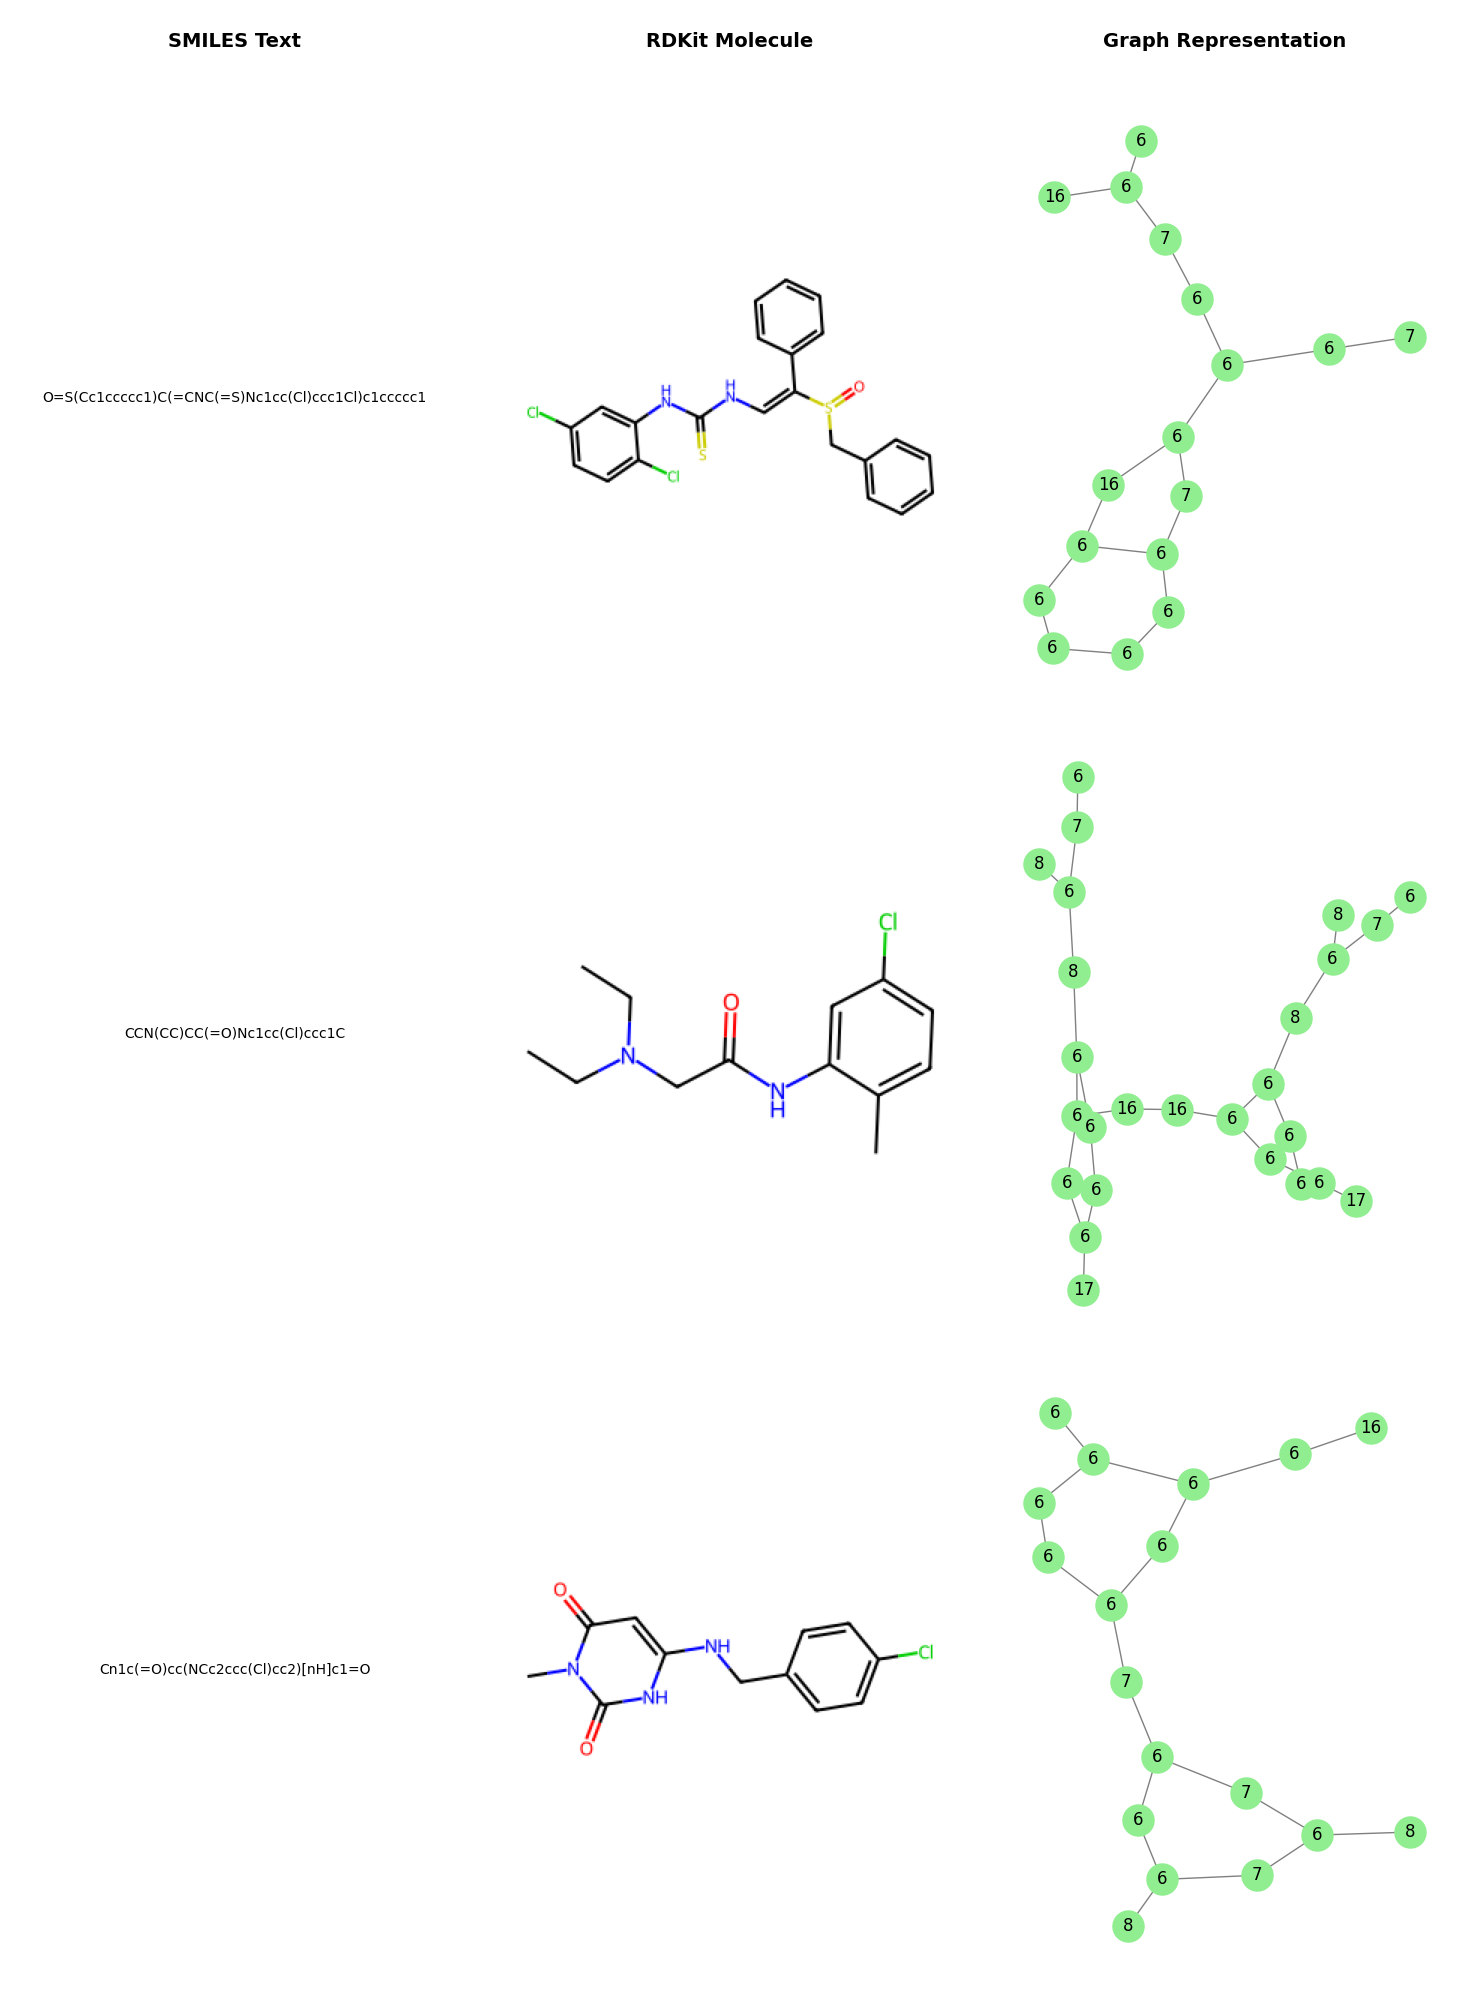

In [9]:
dataset = HIVDataset(df)
plot_samples_tabular_with_features(dataset, n=3)

## Graph Features

In [77]:
def plot_random_sample_with_selected_nodes(dataset):
    """
    Plot a random sample from the dataset and show detailed features only for 3 randomly selected nodes.
    All nodes are labeled with their node index only.
    Also, annotate 3 unique edges with their features.
    """
    idx = random.randint(0, len(dataset) - 1)
    sample = dataset[idx]
    row_data = dataset.dataframe.iloc[idx]
    smiles = row_data['smiles']
    
    G = nx.Graph()
    num_nodes = sample.x.shape[0]
    
    node_features = []
    for j in range(num_nodes):
        features_tensor = sample.x[j]
        atomic_number     = int(features_tensor[0].item())
        period            = int(features_tensor[1].item())
        group             = int(features_tensor[2].item())
        combined_index    = int(features_tensor[3].item())
        degree            = int(features_tensor[4].item())
        formal_charge     = int(features_tensor[5].item())
        hybridization     = int(features_tensor[6].item())
        aromaticity       = int(features_tensor[7].item())
        total_hs          = int(features_tensor[8].item())
        radical_electrons = int(features_tensor[9].item())
        in_ring           = int(features_tensor[10].item())
        chirality         = int(features_tensor[11].item())
        
        node_features.append({
            'atomic_number': atomic_number,
            'period': period,
            'group': group,
            'combined_index': combined_index,
            'degree': degree,
            'formal_charge': formal_charge,
            'hybridization': hybridization,
            'aromaticity': aromaticity,
            'total_hydrogens': total_hs,
            'radical_electrons': radical_electrons,
            'in_ring': in_ring,
            'chirality': chirality
        })
        G.add_node(j, label=str(j))
    
    for j in range(sample.edge_index.shape[1]):
        src = sample.edge_index[0, j].item()
        dst = sample.edge_index[1, j].item()
        G.add_edge(src, dst)
    
    labels_dict = {node: str(node) for node in G.nodes()}
    
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, labels=labels_dict,
            node_color='lightgreen', edge_color='gray', node_size=800)
    
    selected_nodes = random.sample(range(num_nodes), min(3, num_nodes))
    for node in selected_nodes:
        features = node_features[node]
        feature_text = (
            f"AN: {features['atomic_number']}\n"
            f"CI: {features['combined_index']}\n"
            f"D: {features['degree']}\n"
            f"FC: {features['formal_charge']}\n"
            f"Hy: {features['hybridization']}\n"
            f"Ar: {features['aromaticity']}\n"
            f"H: {features['total_hydrogens']}\n"
            f"Rad: {features['radical_electrons']}\n"
            f"InRing: {features['in_ring']}\n"
            f"Ch: {features['chirality']}"
        )
        x, y = pos[node]
        plt.text(x + 0.05, y + 0.05, feature_text, fontsize=10, ha='left', va='bottom',
                 bbox=dict(facecolor='white', alpha=0.7))
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color='lightgreen',
                               node_size=800, edgecolors='red', linewidths=2)
    
    edge_features_dict = {}
    num_edges = sample.edge_index.shape[1]
    for j in range(num_edges):
        src = sample.edge_index[0, j].item()
        dst = sample.edge_index[1, j].item()
        key = tuple(sorted((src, dst)))
        if key not in edge_features_dict:
            feat = sample.edge_attr[j].tolist()
            edge_features_dict[key] = feat

    unique_edges = list(edge_features_dict.keys())
    if unique_edges:
        selected_edges = random.sample(unique_edges, min(3, len(unique_edges)))
        for edge in selected_edges:
            feat = edge_features_dict[edge]
            # Compute the midpoint.
            x_mid = (pos[edge[0]][0] + pos[edge[1]][0]) / 2
            y_mid = (pos[edge[0]][1] + pos[edge[1]][1]) / 2
            edge_text = f"Bond: {feat[0]:.2f}\nRing: {int(feat[1])}"
            plt.text(x_mid, y_mid, edge_text, fontsize=10, ha='center', va='center',
                     bbox=dict(facecolor='yellow', alpha=0.7))
    
    plt.title(f"SMILES: {smiles}", fontsize=16)
    plt.show()


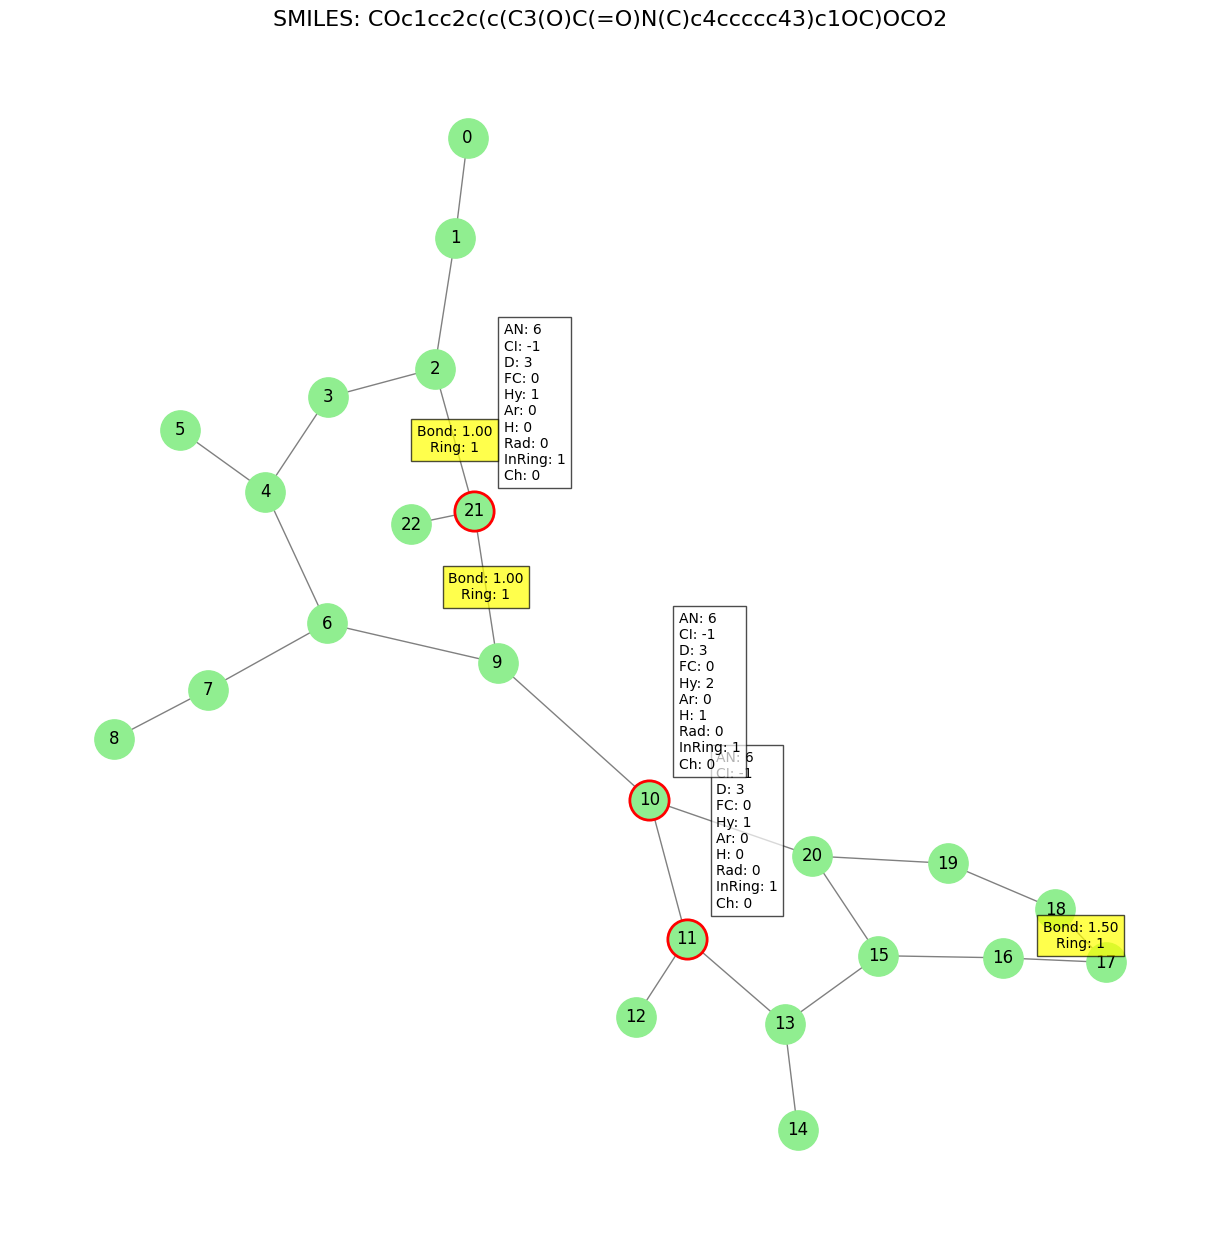

In [82]:
plot_random_sample_with_selected_nodes(dataset)

## Data Distribution

In [12]:
def plot_activity_and_hiv_active_distribution(dataset):
    """
    Plot the distribution of the 'activity' and 'HIV_active' columns.
    """
    activity_counts = dataset.dataframe['activity'].value_counts()

    hiv_active_counts = dataset.dataframe['HIV_active'].value_counts()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    activity_counts.plot(kind='bar', ax=axes[0], color='lightblue')
    axes[0].set_title('Distribution of Activity', fontsize=14)
    axes[0].set_xlabel('Activity', fontsize=12)
    axes[0].set_ylabel('Number of Samples', fontsize=12)
    axes[0].tick_params(axis='x', rotation=0)

    hiv_active_counts.plot(kind='bar', ax=axes[1], color='salmon')
    axes[1].set_title('Distribution of HIV Active', fontsize=14)
    axes[1].set_xlabel('HIV Active', fontsize=12)
    axes[1].set_ylabel('Number of Samples', fontsize=12)
    axes[1].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()

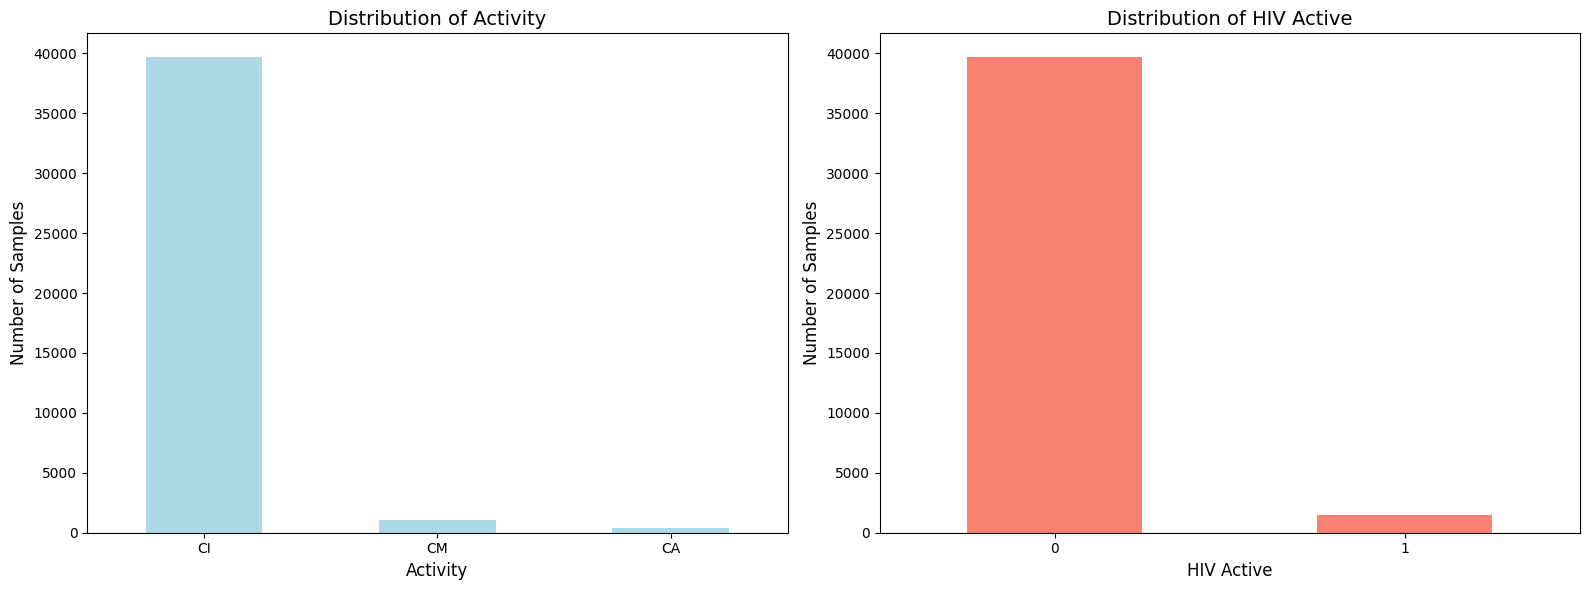

In [13]:
plot_activity_and_hiv_active_distribution(dataset)

# Data Preprocessing

## Train Test Split

In [14]:
dataset_df = dataset.dataframe

train_df, test_df = train_test_split(dataset_df, test_size=0.2, stratify=dataset_df['HIV_active'], random_state=42)

train_dataset = HIVDataset(dataframe=train_df)
test_dataset = HIVDataset(dataframe=test_df)

[17:47:20] Explicit valence for atom # 13 Al, 7, is greater than permitted
[17:47:24] Explicit valence for atom # 16 Al, 9, is greater than permitted
[17:47:24] Explicit valence for atom # 6 Ge, 5, is greater than permitted
[17:47:25] Explicit valence for atom # 3 Al, 6, is greater than permitted
[17:47:27] WARNING: not removing hydrogen atom without neighbors
[17:47:27] WARNING: not removing hydrogen atom without neighbors
[17:47:27] Explicit valence for atom # 5 B, 5, is greater than permitted
[17:47:29] Explicit valence for atom # 4 Al, 9, is greater than permitted
[17:47:30] Explicit valence for atom # 12 Al, 7, is greater than permitted


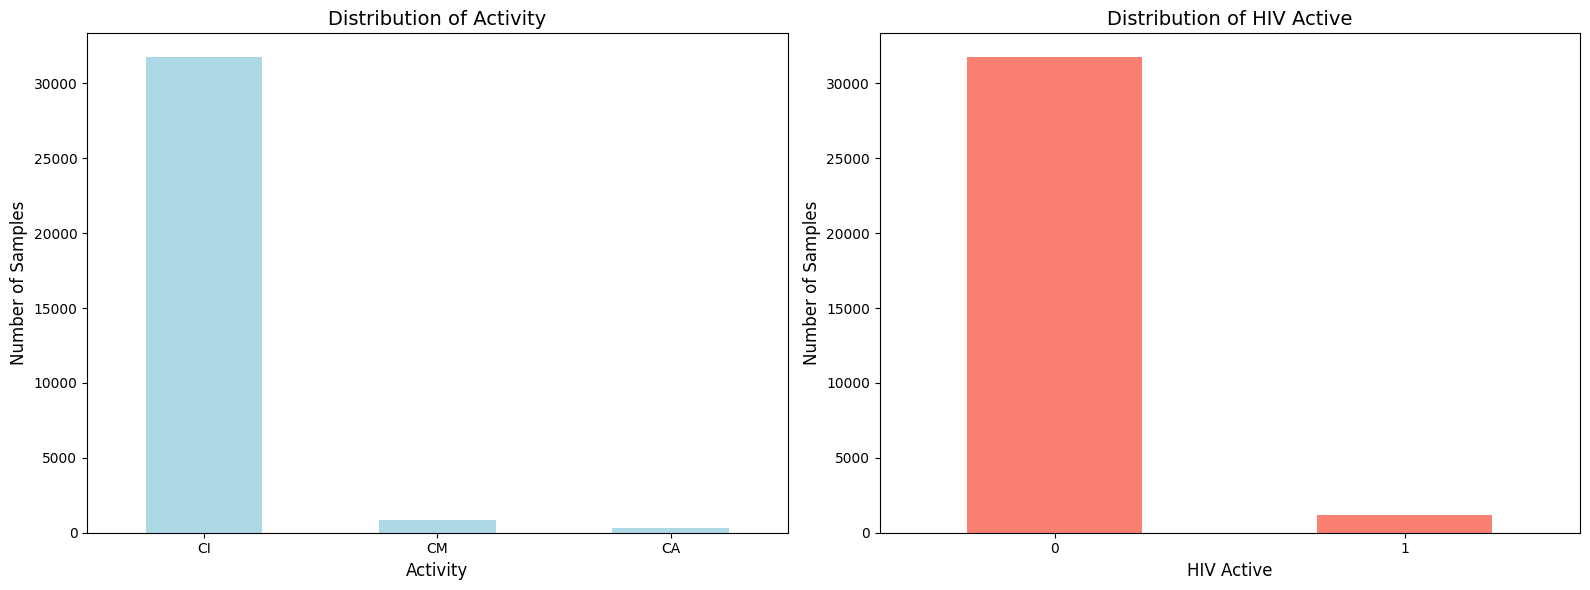

In [15]:
plot_activity_and_hiv_active_distribution(train_dataset)

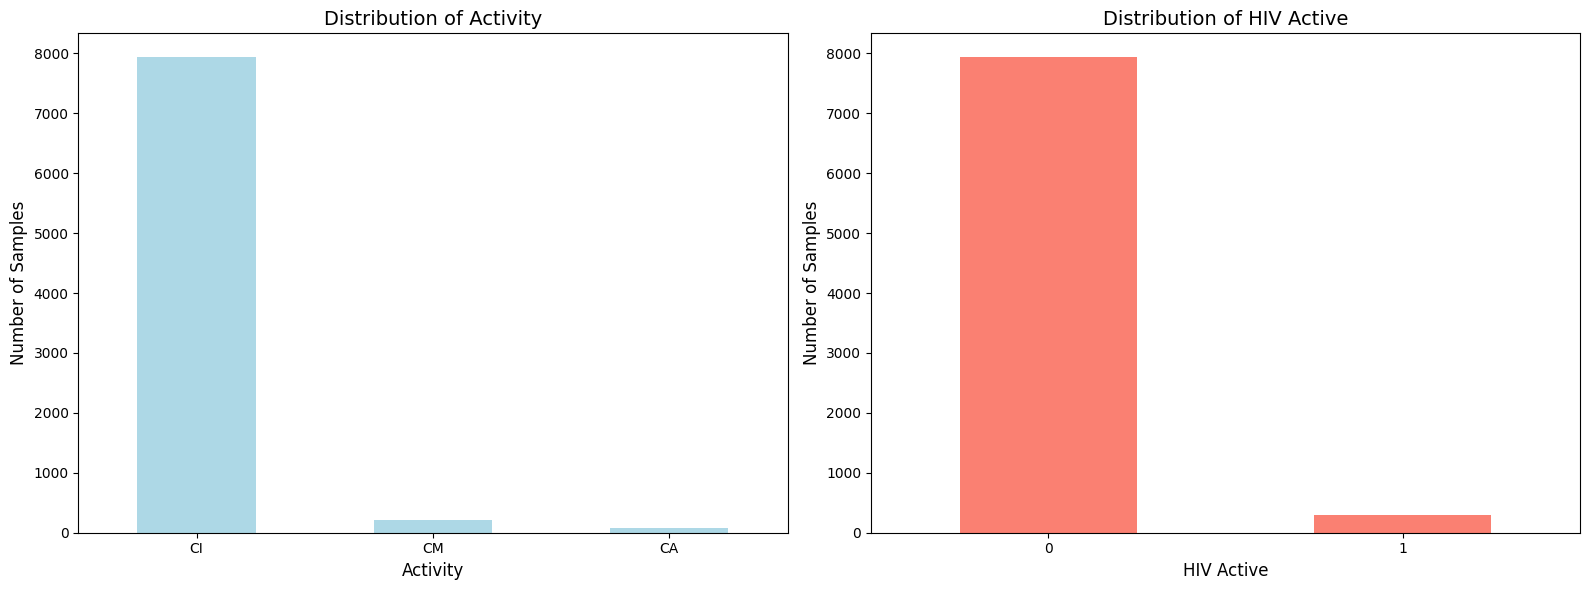

In [16]:
plot_activity_and_hiv_active_distribution(test_dataset)

## Molecular Distribution

[17:47:38] Explicit valence for atom # 13 Al, 7, is greater than permitted
[17:47:38] Explicit valence for atom # 13 Al, 7, is greater than permitted
[17:47:54] Explicit valence for atom # 16 Al, 9, is greater than permitted
[17:47:54] Explicit valence for atom # 16 Al, 9, is greater than permitted
[17:47:57] Explicit valence for atom # 6 Ge, 5, is greater than permitted
[17:47:57] Explicit valence for atom # 6 Ge, 5, is greater than permitted
[17:47:59] Explicit valence for atom # 3 Al, 6, is greater than permitted
[17:47:59] Explicit valence for atom # 3 Al, 6, is greater than permitted
[17:48:07] WARNING: not removing hydrogen atom without neighbors
[17:48:07] WARNING: not removing hydrogen atom without neighbors
[17:48:07] WARNING: not removing hydrogen atom without neighbors
[17:48:07] WARNING: not removing hydrogen atom without neighbors
[17:48:10] Explicit valence for atom # 5 B, 5, is greater than permitted
[17:48:10] Explicit valence for atom # 5 B, 5, is greater than permitte

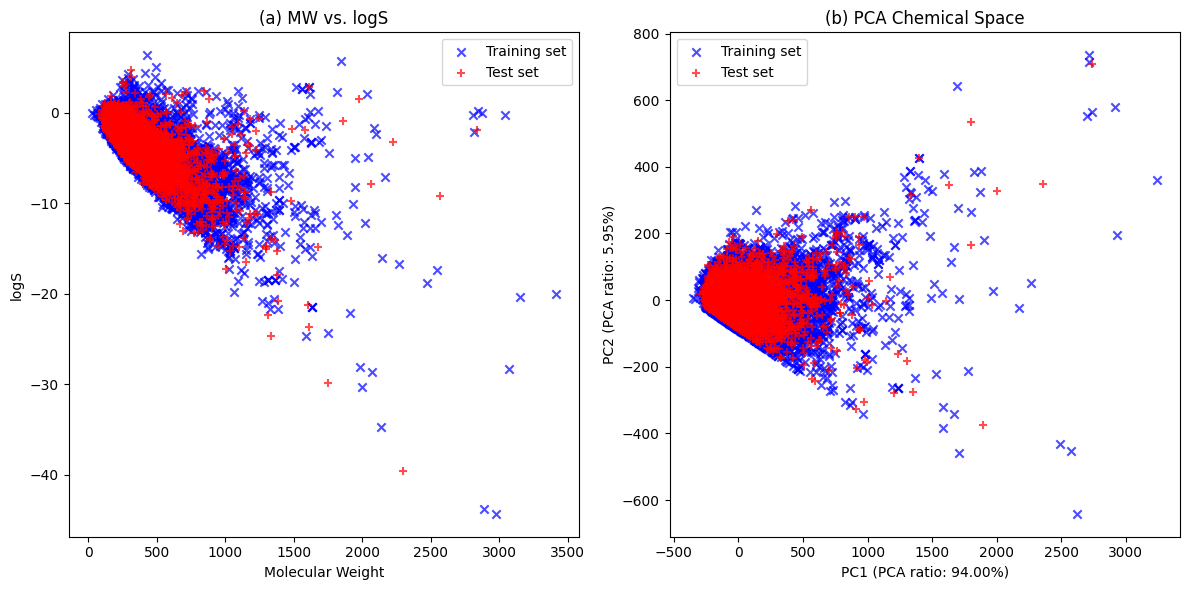

In [17]:
def compute_mw_logS(smiles):
    """ Compute MW and aqueous solubility (logS) using an ESOL-like equation. """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None
    MW = Descriptors.MolWt(mol)
    logP = Crippen.MolLogP(mol)
    num_rot = Lipinski.NumRotatableBonds(mol)
    logS = 0.16 - 0.63 * logP - 0.0062 * MW + 0.066 * num_rot
    return MW, logS

def compute_descriptor_features(smiles):
    """ Compute descriptors for PCA. """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    MW = Descriptors.MolWt(mol)
    logP = Crippen.MolLogP(mol)
    num_rot = Lipinski.NumRotatableBonds(mol)
    tpsa = Descriptors.TPSA(mol)
    h_donors = Lipinski.NumHDonors(mol)
    h_acceptors = Lipinski.NumHAcceptors(mol)
    return [MW, logP, num_rot, tpsa, h_donors, h_acceptors]

def plot_combined_chemical_space(train_df, test_df):
    """ 
    Plot MW vs logS and PCA components, combining training and test sets. 
    Training set: Blue (x), Test set: Red (+).
    """
    train_mw, train_logS, train_features = [], [], []
    test_mw, test_logS, test_features = [], [], []

    for s in train_df['smiles']:
        mw, logS = compute_mw_logS(s)
        feat = compute_descriptor_features(s)
        if mw is not None and feat is not None:
            train_mw.append(mw)
            train_logS.append(logS)
            train_features.append(feat)

    for s in test_df['smiles']:
        mw, logS = compute_mw_logS(s)
        feat = compute_descriptor_features(s)
        if mw is not None and feat is not None:
            test_mw.append(mw)
            test_logS.append(logS)
            test_features.append(feat)

    all_features = np.array(train_features + test_features)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(all_features)
    
    train_pca = principal_components[:len(train_features)]
    test_pca = principal_components[len(train_features):]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].scatter(train_mw, train_logS, color='blue', label="Training set", marker='x', alpha=0.7)
    axes[0].scatter(test_mw, test_logS, color='red', label="Test set", marker='+', alpha=0.7)
    axes[0].set_xlabel("Molecular Weight")
    axes[0].set_ylabel("logS")
    axes[0].set_title("(a) MW vs. logS")
    axes[0].legend()

    axes[1].scatter(train_pca[:, 0], train_pca[:, 1], color='blue', label="Training set", marker='x', alpha=0.7)
    axes[1].scatter(test_pca[:, 0], test_pca[:, 1], color='red', label="Test set", marker='+', alpha=0.7)
    axes[1].set_xlabel(f"PC1 (PCA ratio: {pca.explained_variance_ratio_[0]*100:.2f}%)")
    axes[1].set_ylabel(f"PC2 (PCA ratio: {pca.explained_variance_ratio_[1]*100:.2f}%)")
    axes[1].set_title("(b) PCA Chemical Space")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_combined_chemical_space(train_df, test_df)

## Oversampling Train Set

In [18]:
X_train = train_df[['smiles']].values
y_train = train_df['HIV_active'].values
activity_train = train_df['activity'].values

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

sample_indices = ros.sample_indices_

activity_resampled = activity_train[sample_indices]

oversampled_df = pd.DataFrame({
    'smiles': X_resampled.flatten(),
    'HIV_active': y_resampled,
    'activity': activity_resampled
})

train_balanced_dataset = HIVDataset(oversampled_df)

[17:48:29] Explicit valence for atom # 13 Al, 7, is greater than permitted
[17:48:33] Explicit valence for atom # 16 Al, 9, is greater than permitted
[17:48:33] Explicit valence for atom # 6 Ge, 5, is greater than permitted
[17:48:34] Explicit valence for atom # 3 Al, 6, is greater than permitted
[17:48:36] WARNING: not removing hydrogen atom without neighbors
[17:48:36] WARNING: not removing hydrogen atom without neighbors
[17:48:37] Explicit valence for atom # 5 B, 5, is greater than permitted


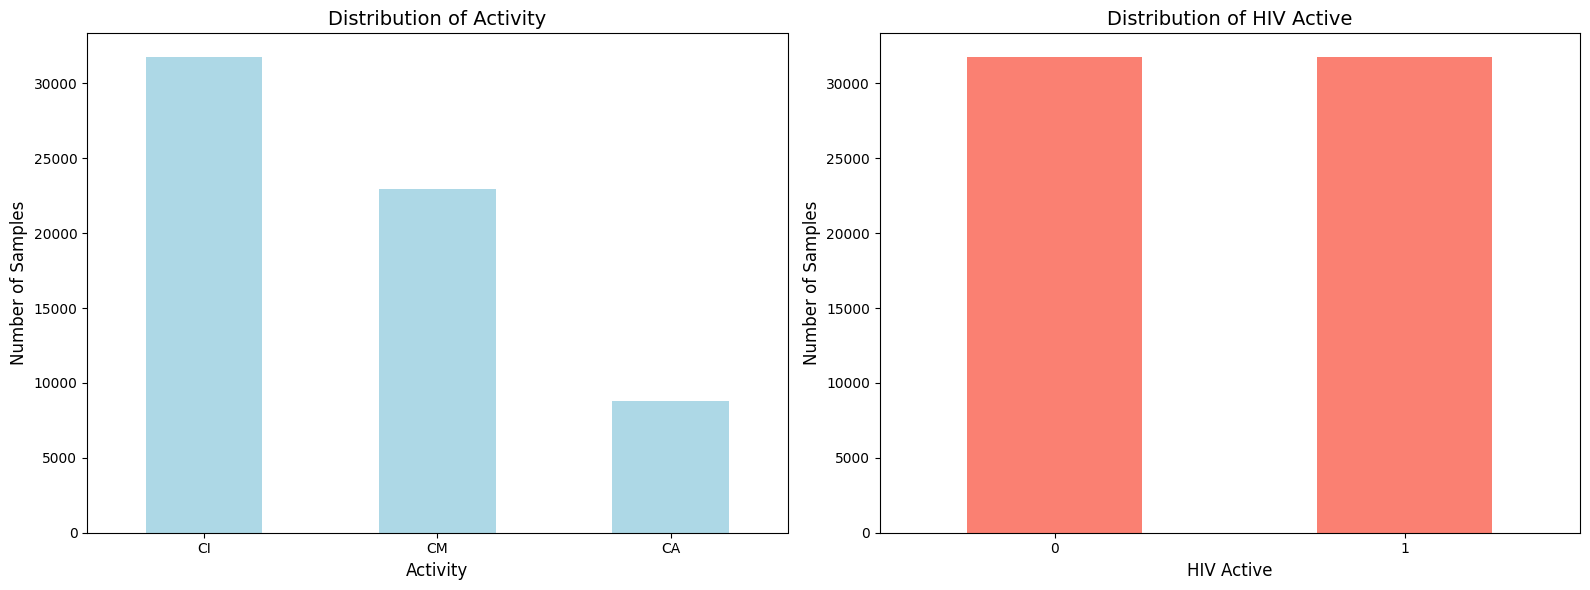

In [19]:
plot_activity_and_hiv_active_distribution(train_balanced_dataset)

# Models

## GCN Model

In [20]:
class GCN(torch.nn.Module):
    def __init__(self, feature_size, model_params):
        super(GCN, self).__init__()
        embedding_size = model_params["model_embedding_size"][0]
        self.n_layers = model_params["model_layers"][0]
        dropout_rate = model_params["model_dropout_rate"][0]
        self.dropout_rate = dropout_rate
        top_k_ratio = model_params["model_top_k_ratio"][0]
        self.top_k_every_n = model_params["model_top_k_every_n"][0]
        dense_neurons = model_params["model_dense_neurons"][0]
        self.ignore_edge_features = model_params.get("ignore_edge_features", [False])[0]

        self.conv_layers = ModuleList([])
        self.pooling_layers = ModuleList([])
        self.bn_layers = ModuleList([])

        self.conv1 = GCNConv(feature_size, embedding_size)
        self.bn1 = BatchNorm1d(embedding_size)

        for i in range(self.n_layers):
            self.conv_layers.append(GCNConv(embedding_size, embedding_size))
            self.bn_layers.append(BatchNorm1d(embedding_size))
            if i % self.top_k_every_n == 0:
                self.pooling_layers.append(TopKPooling(embedding_size, ratio=top_k_ratio))

        self.linear1 = Linear(embedding_size * 2, dense_neurons)
        self.linear2 = Linear(dense_neurons, int(dense_neurons / 2))
        self.linear3 = Linear(int(dense_neurons / 2), 1)

    def forward(self, x, edge_index, edge_attr, batch_index):
        if self.ignore_edge_features:
            edge_attr = None

        x = self.conv1(x, edge_index)
        x = torch.relu(self.bn1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        global_representation = []
        for i in range(self.n_layers):
            x_in = x
            x = self.conv_layers[i](x, edge_index)
            x = self.bn_layers[i](x)
            x = x + x_in
            x = torch.relu(x)
            x = F.dropout(x, p=self.dropout_rate, training=self.training)
            
            if i % self.top_k_every_n == 0 or i == self.n_layers - 1:
                pool_idx = int(i / self.top_k_every_n)
                x, edge_index, edge_attr, batch_index, _, _ = self.pooling_layers[pool_idx](
                    x, edge_index, edge_attr, batch_index
                )
                global_representation.append(torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1))

        x = sum(global_representation)
        x = torch.relu(self.linear1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = torch.relu(self.linear2(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.linear3(x)
        return x

## GAT Model

In [21]:
class GAT(torch.nn.Module):
    def __init__(self, feature_size, model_params):
        super(GAT, self).__init__()
        embedding_size = model_params["model_embedding_size"][0]
        n_heads = model_params["model_attention_heads"][0]
        self.n_layers = model_params["model_layers"][0]
        dropout_rate = model_params["model_dropout_rate"][0]
        self.dropout_rate = dropout_rate
        top_k_ratio = model_params["model_top_k_ratio"][0]
        self.top_k_every_n = model_params["model_top_k_every_n"][0]
        dense_neurons = model_params["model_dense_neurons"][0]

        self.conv_layers = ModuleList([])
        self.pooling_layers = ModuleList([])
        self.bn_layers = ModuleList([])

        self.conv1 = GATConv(feature_size, embedding_size, heads=n_heads, dropout=dropout_rate)
        self.bn1 = BatchNorm1d(embedding_size * n_heads)

        for i in range(self.n_layers):
            self.conv_layers.append(
                GATConv(embedding_size * n_heads, embedding_size, heads=n_heads, dropout=dropout_rate)
            )
            self.bn_layers.append(
                BatchNorm1d(embedding_size * n_heads)
            )
            if i % self.top_k_every_n == 0:
                self.pooling_layers.append(
                    TopKPooling(embedding_size * n_heads, ratio=top_k_ratio)
                )

        self.linear1 = Linear(embedding_size * n_heads * 2, dense_neurons)
        self.linear2 = Linear(dense_neurons, int(dense_neurons / 2))
        self.linear3 = Linear(int(dense_neurons / 2), 1)

    def forward(self, x, edge_index, edge_attr, batch_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(self.bn1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        global_representation = []
        for i in range(self.n_layers):
            x = self.conv_layers[i](x, edge_index)
            x = self.bn_layers[i](x)
            x = x + x_in
            x = torch.relu(x)
            x = F.dropout(x, p=self.dropout_rate, training=self.training)
            
            if i % self.top_k_every_n == 0 or i == self.n_layers - 1:
                pool_idx = int(i / self.top_k_every_n)
                x, edge_index, edge_attr, batch_index, _, _ = self.pooling_layers[pool_idx](
                    x, edge_index, edge_attr, batch_index
                )
                global_representation.append(torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1))

        x = sum(global_representation)
        x = torch.relu(self.linear1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = torch.relu(self.linear2(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.linear3(x)
        return x


## GIN Model

In [22]:
class GIN(torch.nn.Module):
    def __init__(self, feature_size, model_params):
        super(GIN, self).__init__()
        embedding_size = model_params["model_embedding_size"][0]
        self.n_layers = model_params["model_layers"][0]
        dropout_rate = model_params["model_dropout_rate"][0]
        self.dropout_rate = dropout_rate
        top_k_ratio = model_params["model_top_k_ratio"][0]
        self.top_k_every_n = model_params["model_top_k_every_n"][0]
        dense_neurons = model_params["model_dense_neurons"][0]

        self.conv_layers = nn.ModuleList([])
        self.bn_layers = nn.ModuleList([])
        self.pooling_layers = nn.ModuleList([])

        self.conv1 = GINConv(nn.Sequential(
            nn.Linear(feature_size, embedding_size),
            nn.ReLU(),
            nn.Linear(embedding_size, embedding_size)
        ))
        self.bn1 = nn.BatchNorm1d(embedding_size)

        for i in range(self.n_layers):
            self.conv_layers.append(GINConv(nn.Sequential(
                nn.Linear(embedding_size, embedding_size),
                nn.ReLU(),
                nn.Linear(embedding_size, embedding_size)
            )))
            self.bn_layers.append(nn.BatchNorm1d(embedding_size))
            if i % self.top_k_every_n == 0:
                self.pooling_layers.append(TopKPooling(embedding_size, ratio=top_k_ratio))

        self.linear1 = nn.Linear(embedding_size * 2, dense_neurons)
        self.linear2 = nn.Linear(dense_neurons, int(dense_neurons / 2))
        self.linear3 = nn.Linear(int(dense_neurons / 2), 1)

    def forward(self, x, edge_index, edge_attr, batch_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(self.bn1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        global_representation = []
        for i in range(self.n_layers):
            x_in = x
            x = self.conv_layers[i](x, edge_index)
            x = self.bn_layers[i](x)
            x = x + x_in
            x = torch.relu(x)
            x = F.dropout(x, p=self.dropout_rate, training=self.training)
            if i % self.top_k_every_n == 0 or i == self.n_layers - 1:
                pool_idx = int(i / self.top_k_every_n)
                x, edge_index, edge_attr, batch_index, _, _ = self.pooling_layers[pool_idx](
                    x, edge_index, edge_attr, batch_index
                )
                global_representation.append(torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1))
        x = sum(global_representation)
        x = torch.relu(self.linear1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = torch.relu(self.linear2(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.linear3(x)
        return x


## TransformerConv Model

In [23]:
class TransformerGNN(torch.nn.Module):
    def __init__(self, feature_size, model_params):
        super(TransformerGNN, self).__init__()
        embedding_size = model_params["model_embedding_size"][0]
        n_heads = model_params["model_attention_heads"][0]
        self.n_layers = model_params["model_layers"][0]
        dropout_rate = model_params["model_dropout_rate"][0]
        self.dropout_rate = dropout_rate
        top_k_ratio = model_params["model_top_k_ratio"][0]
        self.top_k_every_n = model_params["model_top_k_every_n"][0]
        dense_neurons = model_params["model_dense_neurons"][0]

        self.conv_layers = ModuleList([])
        self.bn_layers = ModuleList([])
        self.pooling_layers = ModuleList([])

        self.conv1 = TransformerConv(feature_size, embedding_size, heads=n_heads, dropout=dropout_rate)
        self.bn1 = BatchNorm1d(embedding_size * n_heads)

        for i in range(self.n_layers):
            self.conv_layers.append(
                TransformerConv(embedding_size * n_heads, embedding_size, heads=n_heads, dropout=dropout_rate)
            )
            self.bn_layers.append(
                BatchNorm1d(embedding_size * n_heads)
            )
            if i % self.top_k_every_n == 0:
                self.pooling_layers.append(
                    TopKPooling(embedding_size * n_heads, ratio=top_k_ratio)
                )

        self.linear1 = Linear(embedding_size * n_heads * 2, dense_neurons)
        self.linear2 = Linear(dense_neurons, int(dense_neurons / 2))
        self.linear3 = Linear(int(dense_neurons / 2), 1)

    def forward(self, x, edge_index, edge_attr, batch_index):
        if edge_attr is not None and edge_attr.size(1) != self.conv1.out_channels:
            edge_attr = None

        x = self.conv1(x, edge_index, edge_attr)
        x = torch.relu(self.bn1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        global_representation = []
        for i in range(self.n_layers):
            x_in = x
            x = self.conv_layers[i](x, edge_index, edge_attr)
            x = torch.relu(self.bn_layers[i](x))
            x = x + x_in
            x = F.dropout(x, p=self.dropout_rate, training=self.training)
            if i % self.top_k_every_n == 0 or i == self.n_layers - 1:
                pool_idx = int(i / self.top_k_every_n)
                x, edge_index, edge_attr, batch_index, _, _ = self.pooling_layers[pool_idx](
                    x, edge_index, edge_attr, batch_index
                )
                global_representation.append(torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1))
        x = sum(global_representation)
        x = torch.relu(self.linear1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = torch.relu(self.linear2(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.linear3(x)
        return x

# Training

## Basic Parameters and Setup

In [24]:
in_channels = train_balanced_dataset[0].x.shape[1]
hidden_channels = 64
out_channels = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [26]:
train_loader = GeoDataLoader(train_balanced_dataset, batch_size=32, shuffle=True)
test_loader = GeoDataLoader(test_dataset, batch_size=32, shuffle=False)

## Train and Test Loops

In [27]:
def train_model(model, loader, optimizer, loss_fn, epoch, total_epochs, device):
    """
    Trains the model for one epoch using BCEWithLogitsLoss for binary classification.

    model: A PyTorch model outputting shape [batch_size, 1].
    loader: A DataLoader yielding batches with attributes (x, edge_index, edge_attr, batch, y).
    optimizer: The optimizer (e.g., SGD or Adam).
    loss_fn: BCEWithLogitsLoss(pos_weight=...).
    epoch, total_epochs: For display in tqdm.
    device: The torch device.
    """
    model.train()
    total_loss = 0.0
    y_true_all = []
    y_pred_all = []

    for batch in tqdm(loader, desc=f"Epoch [{epoch}/{total_epochs}] (Train)"):
        batch = batch.to(device)
        optimizer.zero_grad()

        logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)

        targets = batch.y.float().unsqueeze(1)

        loss = loss_fn(logits, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_graphs

        preds = (torch.sigmoid(logits) > 0.5).float()

        y_pred_all.extend(preds.cpu().numpy().flatten())
        y_true_all.extend(batch.y.cpu().numpy().flatten())

    avg_loss = total_loss / len(loader.dataset)

    acc = accuracy_score(y_true_all, y_pred_all)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true_all, y_pred_all, average='binary', zero_division=0
    )

    return avg_loss, acc, prec, rec, f1


def test_model(model, loader, loss_fn, epoch, total_epochs, device):
    """
    Evaluates the model for one epoch using BCEWithLogitsLoss for binary classification.

    model: A PyTorch model outputting shape [batch_size, 1].
    loader: A DataLoader yielding batches with attributes (x, edge_index, edge_attr, batch, y).
    loss_fn: BCEWithLogitsLoss(pos_weight=...).
    epoch, total_epochs: For display in tqdm.
    device: The torch device.
    """
    model.eval()
    total_loss = 0.0
    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Epoch [{epoch}/{total_epochs}] (Eval)"):
            batch = batch.to(device)

            logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)

            targets = batch.y.float().unsqueeze(1)

            loss = loss_fn(logits, targets)
            total_loss += loss.item() * batch.num_graphs

            preds = (torch.sigmoid(logits) > 0.5).float()

            y_pred_all.extend(preds.cpu().numpy().flatten())
            y_true_all.extend(batch.y.cpu().numpy().flatten())

    avg_loss = total_loss / len(loader.dataset)

    acc = accuracy_score(y_true_all, y_pred_all)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true_all, y_pred_all, average='binary', zero_division=0
    )

    return avg_loss, acc, prec, rec, f1

## Optimizer and Evaluation Metrics

In [30]:
def run_training_for_model(model_class, model_name, config, train_loader, test_loader, device, in_channels):
    """
    Instantiates the model using the provided model_class and config, then trains it using:
      - BCEWithLogitsLoss with pos_weight for imbalance
      - SGD with momentum and weight decay
      - ExponentialLR scheduler
    
    The training and evaluation functions are set up for binary classification.
    
    Parameters:
      model_class: The class (or constructor) for the model.
      model_name (str): Name for logging and saving.
      config (dict): Configuration dictionary with hyperparameters.
      train_loader, test_loader: DataLoader objects.
      device: torch.device for training.
      in_channels: Input feature dimension.
    """

    model = model_class(feature_size=in_channels, model_params=config).to(device)
    
    epochs = config["epochs"][0]
    
    weight = torch.tensor([config["pos_weight"][0]], dtype=torch.float32).to(device)
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=weight)
    
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=config["learning_rate"][0],
                                momentum=config["sgd_momentum"][0],
                                weight_decay=config["weight_decay"][0])
    
    # optimizer = torch.optim.Adam(
    #     model.parameters(),
    #     lr=config["learning_rate"][0],
    #     weight_decay=config["weight_decay"][0]
    # )

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=config["scheduler_gamma"][0])
    
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    train_precs, train_recs, train_f1s = [], [], []
    test_precs, test_recs, test_f1s = [], [], []
    
    for epoch in range(1, epochs + 1):
        train_loss, train_acc, train_prec, train_rec, train_f1 = train_model(
            model, train_loader, optimizer, loss_fn, epoch, epochs, device
        )
        test_loss, test_acc, test_prec, test_rec, test_f1 = test_model(
            model, test_loader, loss_fn, epoch, epochs, device
        )
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        train_precs.append(train_prec)
        train_recs.append(train_rec)
        train_f1s.append(train_f1)
        test_precs.append(test_prec)
        test_recs.append(test_rec)
        test_f1s.append(test_f1)
        
        print(f"\nEpoch {epoch}/{epochs} Results for {model_name}:")
        print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | P: {train_prec:.4f} | R: {train_rec:.4f} | F1: {train_f1:.4f}")
        print(f"  Test  Loss: {test_loss:.4f}  | Acc: {test_acc:.4f}  | P: {test_prec:.4f}  | R: {test_rec:.4f}  | F1: {test_f1:.4f}")
        
        scheduler.step()
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    save_dir = "saved_models"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{model_name}_weights_{timestamp}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"\nWeights of {model_name} saved at {save_path}")
    
    epochs_range = range(1, epochs + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, test_losses, label="Test Loss")
    plt.title(f"{model_name} - Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, train_accs, label="Train Accuracy")
    plt.plot(epochs_range, test_accs, label="Test Accuracy")
    plt.title(f"{model_name} - Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, train_precs, label="Train Precision")
    plt.plot(epochs_range, train_recs, label="Train Recall")
    plt.plot(epochs_range, train_f1s, label="Train F1")
    plt.plot(epochs_range, test_precs, '--', label="Test Precision")
    plt.plot(epochs_range, test_recs, '--', label="Test Recall")
    plt.plot(epochs_range, test_f1s, '--', label="Test F1")
    plt.title(f"{model_name} - Precision, Recall, F1 Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    
    print(f"\n{model_name} Final Test Metrics:")
    print(f"  Accuracy:  {test_accs[-1]:.4f}")
    print(f"  Precision: {test_precs[-1]:.4f}")
    print(f"  Recall:    {test_recs[-1]:.4f}")
    print(f"  F1 Score:  {test_f1s[-1]:.4f}")

## Model Config

In [31]:
config = {
    "epochs": [30],
    "batch_size": [128],
    "learning_rate": [0.05],
    "weight_decay": [0.0005],
    "sgd_momentum": [0.8],
    "scheduler_gamma": [0.95],
    "pos_weight": [1.3],
    "model_embedding_size": [128],
    "model_attention_heads": [4],
    "model_layers": [3],
    "model_dropout_rate": [0.2],
    "model_top_k_ratio": [0.5],
    "model_top_k_every_n": [1],
    "model_dense_neurons": [256],
    "ignore_edge_features": [False],
    "model_edge_dim": [2],
}

## Train Run

In [ ]:
# run_training_for_model(GCN, "GCN", config, train_loader, test_loader, device, in_channels)

In [32]:
# run_training_for_model(GAT, "GAT", config, train_loader, test_loader, device, in_channels)

In [33]:
# run_training_for_model(GIN, "GIN", config, train_loader, test_loader, device, in_channels)

In [ ]:
run_training_for_model(TransformerGNN, "TransformerGNN", config, train_loader, test_loader, device, in_channels)

In [ ]:
# import torch
# import os

# save_dir = "saved_models"
# os.makedirs(save_dir, exist_ok=True)

# for model_name, model in models.items():
#     save_path = os.path.join(save_dir, f"{model_name}_weights.pth")
#     torch.save(model.state_dict(), save_path)
#     print(f"Weights of {model_name} saved at {save_path}")